## Python Data fitting with various functions - HW 12
Due Monday Dec 2, 2024



Dowload the data "miniDR17.fits" from the TCU Online Week 14:<br>
<i>NOTE: it is a large-ish file and may take a while.</i>

**However, this is a small version of the full science data file (4 GB) which can be found at:**<br>
https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits


My example below will show how to remove Identified bad data, 
however data that are just bad in one quantity may remain

_Use masking to remove any remaining bad values (typically 9999 or -9999 in this file_ , <b>but check!!!! If you are not sure, ask!!!</b>). 

In [130]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d


# Monte Carlo-version of 2 parameter Curve Fit that can use BOTH x and Y errors
def mcFit2(func, x, y, x_err=0.1, y_err=0.1, p0=[0,0]):
    slope = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])
    return (np.median(slope),np.median(y_ints))


# Monte Carlo-version of 3 parameter Curve Fit that can use BOTH x and Y errors
def mcFit3(func, x, y, x_err=0.1, y_err=0.1,p0=[1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

# Monte Carlo-version of 4 parameter Curve Fit that can use BOTH x and Y errors
def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])
    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


In [132]:
# READ IN FITS FILES
star_hdus = fits.open('miniDR17.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'TEFF'; format = 'E'
    name = 'TEFF_ERR'; format = 'E'
    name = 'LOGG'; format = 'E'
    name = 'LOGG_ERR'; format = 'E'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'SNR'; format = 'E'
    name = 'VHELIO_AVG'; format = 'E'
    name = 'VERR'; format = 'E'
    name = 'FE_H'; format = 'E'
    name = 'FE_H_ERR'; format = 'E'
    name = 'O_FE'; format = 'E'
    name = 'O_FE_ERR'; format = 'E'
    name = 'NI_FE'; format = 'E'
    name = 'NI_FE_ERR'; format = 'E'
    name = 'NVISITS'; format = 'J'
    name = 'VSCATTER'; format = 'E'
    name = 'ASPCAPFLAG'; format = 'K'
    name = 'STARFLAG'; format = 'K'
    name = 'EXTRATARG'; format = 'J'
    name = 'GAIA_PARALLAX'; format = 'E'
    name = 'GAIA_PARALLAX_ERROR'; for

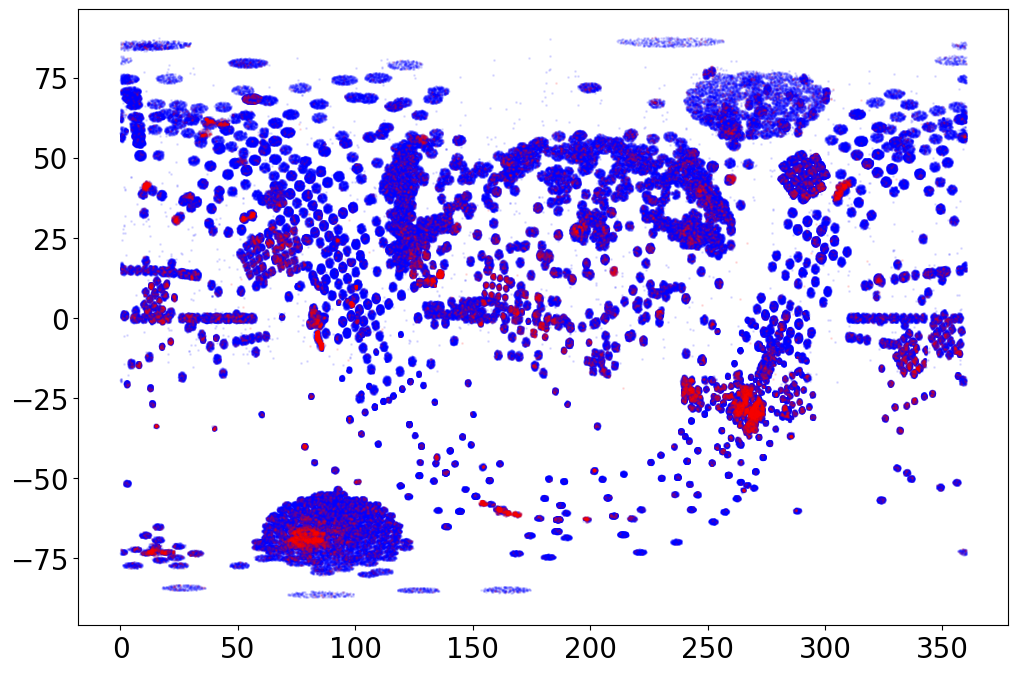

In [134]:
# TWO BITWISE FLAGS FOR BAD DATA - THESE REMOVE IDENTIFIED BAD DATA            
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
bd = (np.bitwise_and(star['aspcapflag'], badbits) != 0) |\
     (np.bitwise_and(star['starflag'], suspectbits) != 0) 

good = np.where(gd)[0]
bad = np.where(bd)[0]

# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(star['RA'][good],star['DEC'][good],s=1,c='b',alpha=0.1)
ax.scatter(star['RA'][bad],star['DEC'][bad],s=1,c='r',alpha=0.1)


ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.show()

LINEAR: -0.074, 16.223
POLY2: 0.005, -1.877, 130.634
COSFIT: 72.947, 0.018, -0.452, -5.700


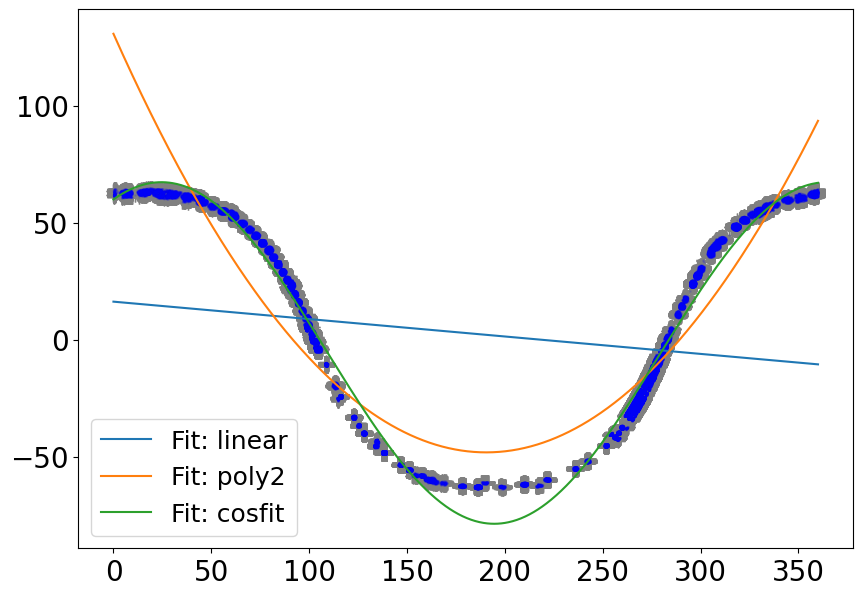

In [12]:
# EXAMPLE FIT - DR. FRINCHABOY
# --------------------------------------------
# First use Linear, Polnomial, and Cosine Fits
# Select stars only with with  −2 < GLAT < 2   
# 
# I FIT RA & DEC data versus LINEAR, POLY2, AND COSFIT in this example.  
#
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] < 2) &\
     (star['GLAT'] > -2) 
cut1 = np.where(ct1)[0]

#=================================================================================
## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['RA'][cut1], star['DEC'][cut1], 0.001, \
                          0.001, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['RA'][cut1], star['DEC'][cut1], 0.001, \
                         0.001,p0=[600,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
## COS FIT (4 parameter)
cfA, cfB, cfC, cfD = mcFit4(cosfit, star['RA'][cut1], star['DEC'][cut1], 0.001, \
                            0.001,p0=[60,0.02,0,0])
print(f'COSFIT: {cfA:.3f}, {cfB:.3f}, {cfC:.3f}, {cfD:.3f}')
#=================================================================================



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['RA'][cut1],star['DEC'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['RA'][cut1]),star['DEC'][cut1], xerr=(0.001),
             yerr=(0.001), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(0,360,1000) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#cosfit
ax1.plot(x_plot,cosfit(x_plot, cfA, cfB, cfC, cfD), label='Fit: cosfit')

plt.legend(loc='best', fontsize=18)
plt.show()

# Homework #12

**REMINDER:** *All coding assignment will be turned in as .ipynb files, to the same PHYS_X0223 repository on GitHub.*   
*They should be turned in with the following naming:*
    
    Lastname_Firstinitial_24_HW12a.ipynb

## DATA FIT 1

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
1. Select stars only with with $ GLAT > 20$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.2, 0.1
POLY2: -0.1, -0.3, 0.048183
POLY3: 0.1, 0.1, -0.3, 0.0


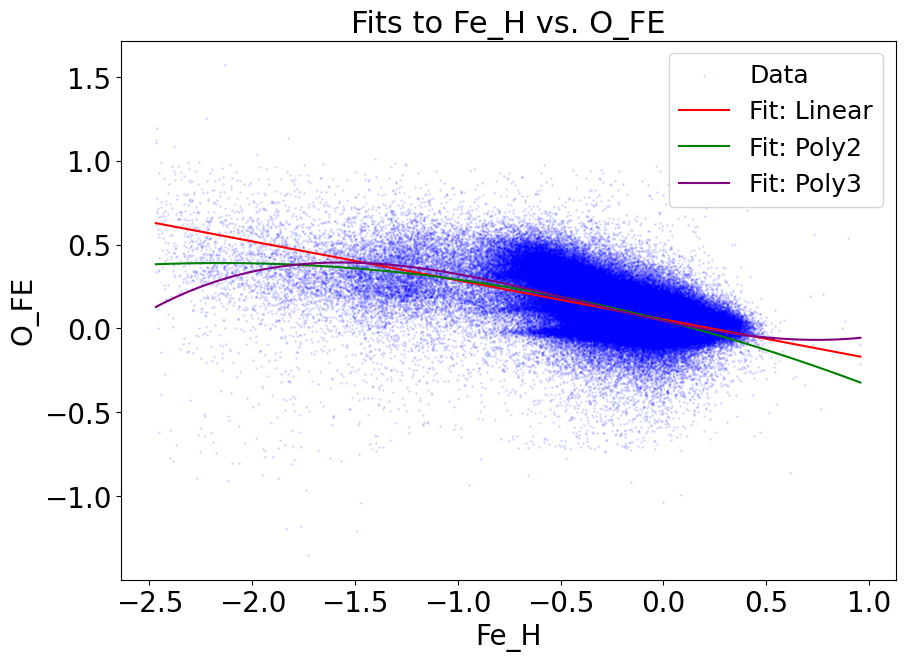

In [227]:
# Bitwise flags to remove bad data
badbits = 2**23        
suspectbits = 2**16   

# Boolean mask to filter data based on criteria
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] > 20) &\
     (~np.isnan(star["Fe_H"])) &\
     (~np.isnan(star["O_FE"]))

# Indices of data passing the criteria
cut1 = np.where(ct1)

# Define data and errors for fitting
x_data = star['Fe_H'][cut1]
y_data = star['O_FE'][cut1]
#x_err = star['Fe_H_ERR'][cut1]
#y_err = star['O_FE_ERR'][cut1]

# Linear Fit
slope, intercept = mcFit2(linear, x_data, y_data, x_err, y_err, p0=[0, 0])
print(f'LINEAR: {slope:.1f}, {intercept:.1f}')

# Polynomial (degree 2) Fit
polyA, polyB, polyC = mcFit3(poly2, x_data, y_data, x_err, y_err, p0=[0, 0, 0])
print(f'POLY2: {polyA:.1f}, {polyB:.1f}, {polyC:.6f}')

# Polynomial (degree 3) Fit
poly3A, poly3B, poly3C, poly3D = mcFit4(poly3, x_data, y_data, x_err, y_err, p0=[0, 0, 0, 0])
print(f'POLY3: {poly3A:.1f}, {poly3B:.1f}, {poly3C:.1f}, {poly3D:.1f}')

# Plotting the results
fig1 = plt.figure(figsize=(10, 7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# Scatter plot of the data
ax1.scatter(x_data, y_data, s=1, c='b', alpha=0.1, label='Data')
#ax1.errorbar(x_data, y_data, xerr=x_err, yerr=y_err, ecolor='grey', fmt='none', capsize=5, zorder=0)

# Create a range of x-values for plotting fits
x_plot = np.linspace(min(x_data), max(x_data), 100)

# Plot fits
ax1.plot(x_plot, linear(x_plot, slope, intercept), label='Fit: Linear', color='r')
ax1.plot(x_plot, poly2(x_plot, polyA, polyB, polyC), label='Fit: Poly2', color='g')
ax1.plot(x_plot, poly3(x_plot, poly3A, poly3B, poly3C, poly3D), label='Fit: Poly3', color='purple')

# Add legend and show plot
plt.legend(loc='best', fontsize=18)
plt.xlabel('Fe_H', fontsize=20)
plt.ylabel('O_FE', fontsize=20)
plt.title('Fits to Fe_H vs. O_FE', fontsize=22)
plt.show()


## DATA FIT 2

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
2. Select stars only with with $-1< GLAT < 1$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.1, 0.0
POLY2: -0.0, -0.1, 0.041253
POLY3: 0.1, 0.1, -0.1, 0.0


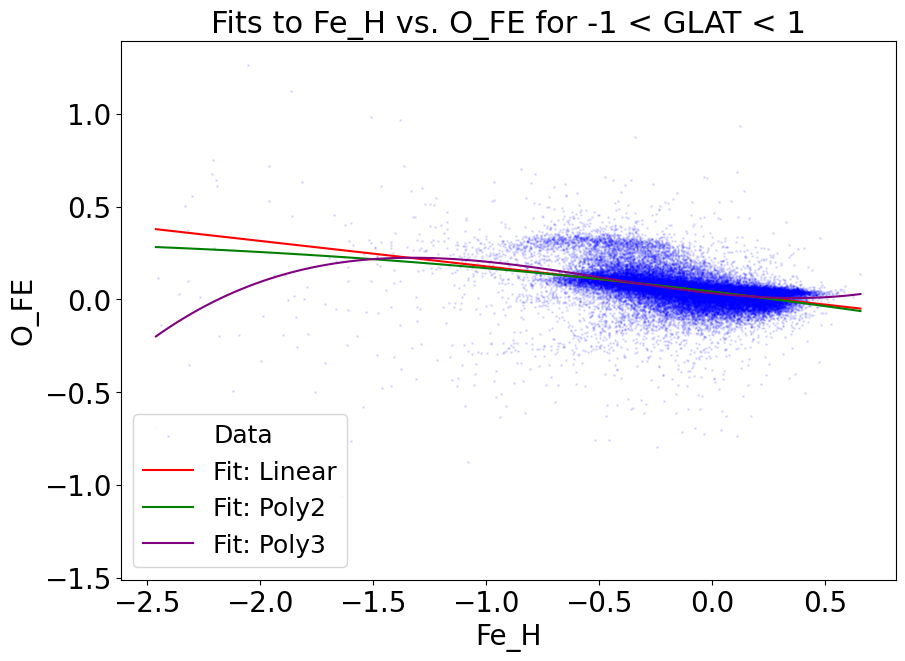

In [115]:
# write your fitting code, from part 1, and plot the results here
# Bitwise flags to remove bad data
badbits = 2**23        
suspectbits = 2**16   

# Boolean mask to filter data based on criteria
ct2 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] > -1) & (star['GLAT'] < 1) & \
     (~np.isnan(star["Fe_H"])) & \
     (~np.isnan(star["O_FE"]))

# Indices of data passing the criteria
cut2 = np.where(ct2)

# Define data and errors for fitting
x_data = star['Fe_H'][cut2]
y_data = star['O_FE'][cut2]
#x_err = star['Fe_H_ERR'][cut2]
#y_err = star['O_FE_ERR'][cut2]

# Linear Fit
slope, intercept = mcFit2(linear, x_data, y_data, x_err, y_err, p0=[0, 0])
print(f'LINEAR: {slope:.1f}, {intercept:.1f}')

# Polynomial (degree 2) Fit
polyA, polyB, polyC = mcFit3(poly2, x_data, y_data, x_err, y_err, p0=[0, 0, 0])
print(f'POLY2: {polyA:.1f}, {polyB:.1f}, {polyC:.6f}')

# Polynomial (degree 3) Fit
poly3A, poly3B, poly3C, poly3D = mcFit4(poly3, x_data, y_data, x_err, y_err, p0=[0, 0, 0, 0])
print(f'POLY3: {poly3A:.1f}, {poly3B:.1f}, {poly3C:.1f}, {poly3D:.1f}')

# Plotting the results
fig2 = plt.figure(figsize=(10, 7))
ax2 = fig2.add_subplot(111)
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)

# Scatter plot of the data
ax2.scatter(x_data, y_data, s=1, c='b', alpha=0.1, label='Data')
#ax2.errorbar(x_data, y_data, xerr=x_err, yerr=y_err, ecolor='grey', fmt='none', capsize=5, zorder=0)

# Create a range of x-values for plotting fits
x_plot = np.linspace(min(x_data), max(x_data), 100)

# Plot fits
ax2.plot(x_plot, linear(x_plot, slope, intercept), label='Fit: Linear', color='r')
ax2.plot(x_plot, poly2(x_plot, polyA, polyB, polyC), label='Fit: Poly2', color='g')
ax2.plot(x_plot, poly3(x_plot, poly3A, poly3B, poly3C, poly3D), label='Fit: Poly3', color='purple')

# Add legend and show plot
plt.legend(loc='best', fontsize=18)
plt.xlabel('Fe_H', fontsize=20)
plt.ylabel('O_FE', fontsize=20)
plt.title('Fits to Fe_H vs. O_FE for -1 < GLAT < 1', fontsize=22)
plt.show()


## DATA FIT 3

Fit a linear, polynomial (poly3), and a exponetial functions and to the following selections of the data:
3. Select stars only with with $340 < GLON < 360$ <br>
   __Fit TEFF,  (TEFF\_ERR)  vs.  LOGG (LOGG\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: slope = 0.0, intercept = -0.1
POLY3: A = 0.0, B = -0.0, C = 0.0, D = -4.8
EXPONENTIAL: A = 0.0, B = -10.0, C = 0.0, D = 0.3


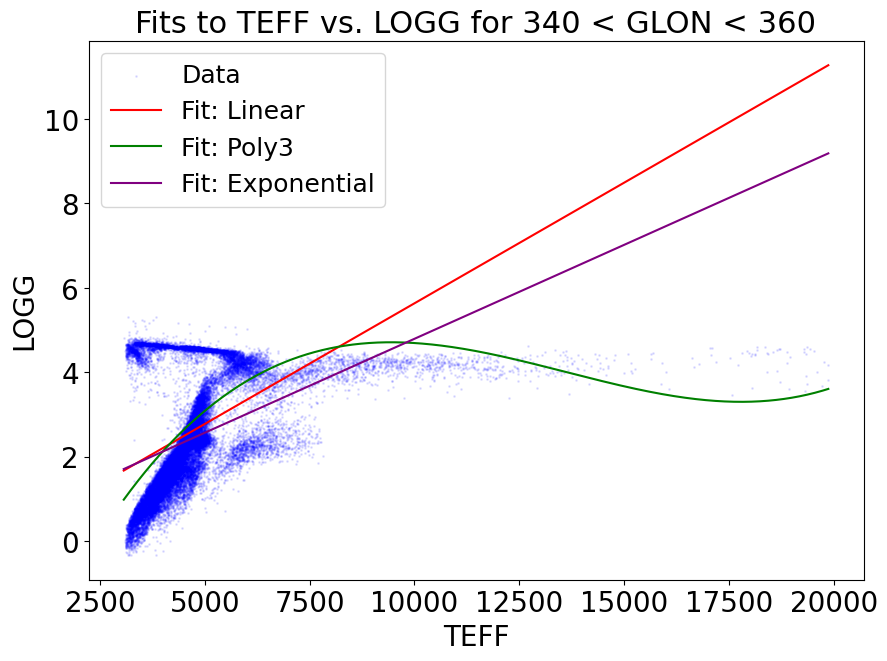

In [116]:
from scipy.optimize import curve_fit

# Exponential function with scaling to avoid overflow
def exponential_scaled(x, A, B, C, D):
    x_scaled = np.log(x)  # Log transformation of x_data to prevent overflow
    return A * np.exp(B * x_scaled) + C * x + D

def exponential(x, A, B, C, D):
    return A * np.exp(B * x) + C * x + D

# Bitwise flags to filter data (not used here but keeping for consistency)
badbits = 2**23
suspectbits = 2**16

# Boolean mask to select stars with 340 < GLON < 360 and valid TEFF, LOGG data
ct3 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      (star["GLON"] > 340) & (star["GLON"] < 360) & \
      (~np.isnan(star["TEFF"])) & (~np.isnan(star["LOGG"])) & \
      (~np.isnan(star["TEFF_ERR"])) & (~np.isnan(star["LOGG_ERR"]))

# Indices of data passing the criteria
cut3 = np.where(ct3)

# Define data and errors for fitting
x_data = star['TEFF'][cut3]
y_data = star['LOGG'][cut3]
#x_err = star['TEFF_ERR'][cut3]
#y_err = star['LOGG_ERR'][cut3]

# Linear Fit
slope, intercept = mcFit2(linear, x_data, y_data, x_err, y_err, p0=[0, 0])
print(f'LINEAR: slope = {slope:.1f}, intercept = {intercept:.1f}')

# Polynomial (degree 3) Fit
polyA, polyB, polyC, polyD = mcFit4(poly3, x_data, y_data, x_err, y_err, p0=[0, 0, 0, 0])
print(f'POLY3: A = {polyA:.1f}, B = {polyB:.1f}, C = {polyC:.1f}, D = {polyD:.1f}')

# Exponential Fit with scaling using curve_fit (adjusting initial guess and bounds)
bounds = ([0, -10, -10, -10], [10, 10, 10, 10])  # Define reasonable bounds for the parameters

# Increase the max number of evaluations
popt, pcov = curve_fit(exponential_scaled, x_data, y_data, p0=[1, 0.1, 1, 1], bounds=bounds, maxfev=10000)
expA, expB, expC, expD = popt
print(f'EXPONENTIAL: A = {expA:.1f}, B = {expB:.1f}, C = {expC:.1f}, D = {expD:.1f}')

# Plotting the results
fig3 = plt.figure(figsize=(10, 7))
ax3 = fig3.add_subplot(111)
ax3.xaxis.set_tick_params(labelsize=20)
ax3.yaxis.set_tick_params(labelsize=20)

# Scatter plot of the data
ax3.scatter(x_data, y_data, s=1, c='b', alpha=0.1, label='Data')

# Create a range of x-values for plotting fits
x_plot = np.linspace(np.min(x_data), np.max(x_data), 1000)  # Adjust the x_range to your data

# Plot fits
ax3.plot(x_plot, linear(x_plot, slope, intercept), label='Fit: Linear', color='r')
ax3.plot(x_plot, poly3(x_plot, polyA, polyB, polyC, polyD), label='Fit: Poly3', color='g')
ax3.plot(x_plot, exponential_scaled(x_plot, expA, expB, expC, expD), label='Fit: Exponential', color='purple')

# Add legend and show plot
plt.legend(loc='best', fontsize=18)
plt.xlabel('TEFF', fontsize=20)
plt.ylabel('LOGG', fontsize=20)
plt.title('Fits to TEFF vs. LOGG for 340 < GLON < 360', fontsize=22)
plt.show()

## DATA FIT 4

Fit  a linear, a exponential, and a polynomial (poly2) functions and to the following selections of the data:
4. Select stars only with with $DEC < -50$ and $50 < RA < 120$ <br>
   __Fit TEFF,  (TEFF\_ERR)   vs.  (star['J'] - star['K']) (JK_ERR)__<br>
<br>
<b>NOTE: you will have to create a (J-K) error:</b>  JK_ERR = np.sqrt( J\_ERR^2 + K\_ERR^2 )<br> 

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

Data points selected: 54221
Linear Fit: Slope = -0.00, Intercept = 1.91
Exponential Fit: A = 6.55, B = -0.00, C = 0.00, D = -1.45
Poly2 Fit: A = 0.00, B = -0.00, C = 3.07


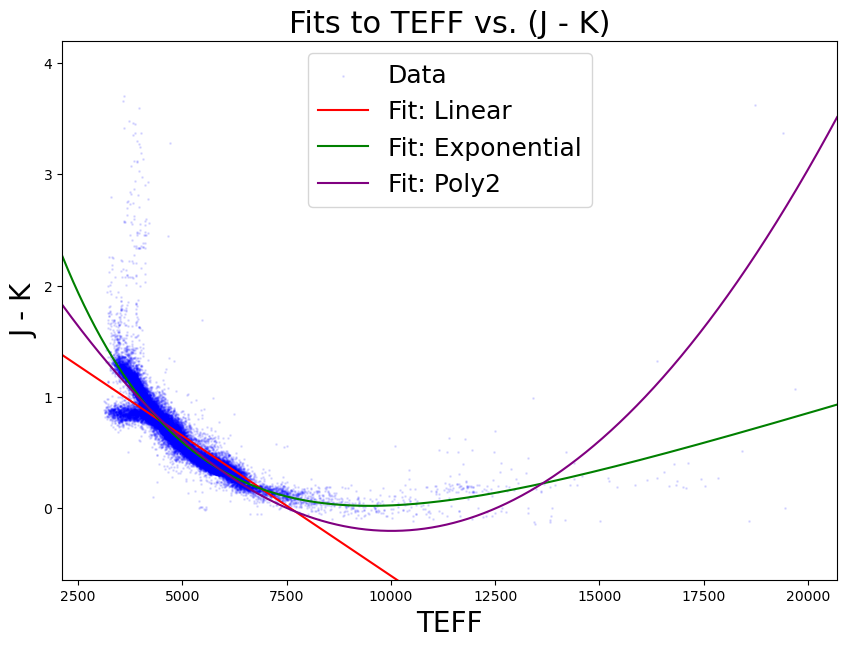

In [186]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the functions to be fitted
def linear(x, a, b):
    return a * x + b

def exponential(x, A, B, C, D):
    return A * np.exp(B * x) + C * x + D

def poly2(x, A, B, C):
    return A * x**2 + B * x + C

# Bitwise flags to filter data
badbits = 2**23
suspectbits = 2**16

# Select stars with DEC < -50 and 50 < RA < 120
ct4 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      (star["DEC"] < -50) & \
      (star["RA"] > 50) & (star["RA"] < 120) & \
      (~np.isnan(star["TEFF"])) & (~np.isnan(star["J"])) & (~np.isnan(star["K"])) & \
      (~np.isnan(star["J_ERR"])) & (~np.isnan(star["K_ERR"]))

# Indices of data passing the criteria
cut4 = np.where(ct4)

# Check if data is selected
x_data = star['TEFF'][cut4]
y_data = star['J'][cut4] - star['K'][cut4]  # J - K

# Calculate the J-K error
JK_ERR = np.sqrt(star['J_ERR'][cut4]**2 + star['K_ERR'][cut4]**2)

# Print data count to check if the filter is working correctly
print(f"Data points selected: {len(x_data)}")

# If there are no data points, stop and debug
if len(x_data) == 0:
    print("No data points after filtering. Please check your filter conditions.")
else:
    # Fit the data with a linear model
    params, _ = curve_fit(linear, x_data, y_data, sigma=JK_ERR, p0=[0, 0])
    slope, intercept = params  # Unpack the linear fit parameters
    print(f'Linear Fit: Slope = {slope:.2f}, Intercept = {intercept:.2f}')

    # Fit the data with an exponential model
    # Use a better guess based on data range
    exp_guess_A = np.max(y_data) - np.min(y_data)
    exp_guess_B = -0.001  # A small negative rate to see a possible decay
    exp_params, exp_cov = curve_fit(exponential, x_data, y_data, sigma=JK_ERR, p0=[exp_guess_A, exp_guess_B, 0, 0])
    print(f'Exponential Fit: A = {exp_params[0]:.2f}, B = {exp_params[1]:.2f}, C = {exp_params[2]:.2f}, D = {exp_params[3]:.2f}')

    # Fit the data with a polynomial of degree 2
    poly_params, poly_cov = curve_fit(poly2, x_data, y_data, sigma=JK_ERR, p0=[0, 0, 0])
    print(f'Poly2 Fit: A = {poly_params[0]:.2f}, B = {poly_params[1]:.2f}, C = {poly_params[2]:.2f}')

    # Plot the results
    fig, ax = plt.subplots(figsize=(10, 7))

    # Scatter plot of the data
    ax.scatter(x_data, y_data, s=1, c='b', alpha=0.1, label='Data')

    # Create a range of x-values for plotting the fits
    # Update the range of x_plot to match the new zoomed-out limits
    x_min, x_max = min(x_data), max(x_data)
    ax.set_xlim(x_min - 1000, x_max + 1000)  # Adjust the x-axis limits
    ax.set_ylim(min(y_data) - 0.5, max(y_data) + 0.5)  # Adjust the y-axis limits
    x_plot = np.linspace(x_min - 1000, x_max + 1000, 20000)  # Adjust x_plot range

    # Plot the fits
    ax.plot(x_plot, linear(x_plot, *params), label='Fit: Linear', color='r')
    ax.plot(x_plot, exponential(x_plot, *exp_params), label='Fit: Exponential', color='g')
    ax.plot(x_plot, poly2(x_plot, *poly_params), label='Fit: Poly2', color='purple')

    # Add labels and legend
    ax.set_xlabel('TEFF', fontsize=20)
    ax.set_ylabel('J - K', fontsize=20)
    ax.set_title('Fits to TEFF vs. (J - K)', fontsize=22)
    plt.legend(loc='best', fontsize=18)

    # Show plot
    plt.show()

## DATA FIT 5

Fit  a linear, a polynomial (poly3), and a cosfit functions and to the following selections of the data:
5. Select stars only with with $-10< GLAT < 10$<br>
   __Fit GLON (0.0001) vs.  VHEILO\_AVG (VERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

Data points selected: 203537
Linear Fit: Slope = -0.01, Intercept = -3.20
Exponential Fit: A = -0.00, B = 0.03, C = 0.12, D = -13.31
Poly2 Fit: A = -0.00, B = 0.09, C = -7.66
Cosine Fit: A = -7.98, B = 1.02, C = -9.21, D = -4.17


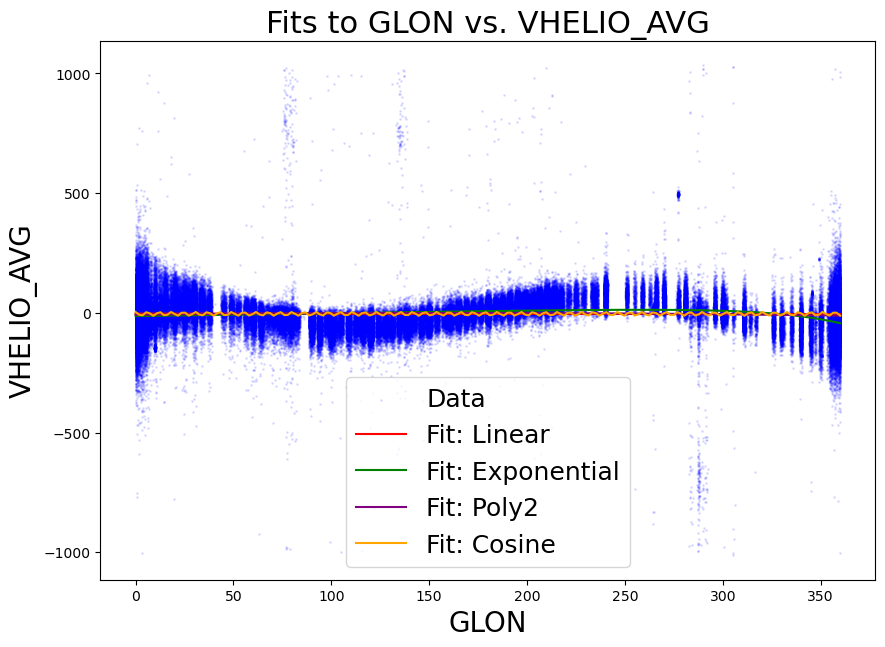

In [253]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the functions to be fitted
def linear(x, a, b):
    return a * x + b

def exponential(x, A, B, C, D):
    return A * np.exp(B * x) + C * x + D

def poly2(x, A, B, C):
    return A * x**2 + B * x + C

def poly3(x, A, B, C, D, E):
    return A * x**3 + B * x**2 + C * x + D

def cosfit(x, A, B, C, D):
    return A * np.cos(B * x + C) + D

badbits = 2**23
suspectbits = 2**16

# Select stars with -10 < GLAT < 10
ct5 = (star["GLAT"] > -10) & (star["GLAT"] < 10) & \
      (~np.isnan(star["GLON"])) & (~np.isnan(star["VHELIO_AVG"]))

# Indices of data passing the criteria
cut5 = np.where(ct5)

# Check if data is selected
x_data = star['GLON'][cut5]
y_data = star['VHELIO_AVG'][cut5]

# Print data count to check if the filter is working correctly
print(f"Data points selected: {len(x_data)}")

# If there are no data points, stop and debug
if len(x_data) == 0:
    print("No data points after filtering. Please check your filter conditions.")
else:
    # Fit the data with a linear model
    params, _ = curve_fit(linear, x_data, y_data, p0=[0, 0])
    slope, intercept = params  # Unpack the linear fit parameters
    print(f'Linear Fit: Slope = {slope:.2f}, Intercept = {intercept:.2f}')

    # Fit the data with an exponential model
    exp_params, exp_cov = curve_fit(exponential, x_data, y_data, p0=[1, 0.1, 1, 1])
    print(f'Exponential Fit: A = {exp_params[0]:.2f}, B = {exp_params[1]:.2f}, C = {exp_params[2]:.2f}, D = {exp_params[3]:.2f}')

    # Fit the data with a polynomial of degree 2 (Poly2)
    poly2_params, poly2_cov = curve_fit(poly2, x_data, y_data, p0=[0, 0, 0])
    print(f'Poly2 Fit: A = {poly2_params[0]:.2f}, B = {poly2_params[1]:.2f}, C = {poly2_params[2]:.2f}')

    # Fit the data with a cosine function
    cos_params, cos_cov = curve_fit(cosfit, x_data, y_data, p0=[1, 1, 0, 0])
    print(f'Cosine Fit: A = {cos_params[0]:.2f}, B = {cos_params[1]:.2f}, C = {cos_params[2]:.2f}, D = {cos_params[3]:.2f}')

    # Plot the results
    fig, ax = plt.subplots(figsize=(10, 7))

    # Scatter plot of the data
    ax.scatter(x_data, y_data, s=1, c='b', alpha=0.1, label='Data')

    # Create a range of x-values for plotting the fits
    x_plot = np.linspace(min(x_data), max(x_data), 200)

    # Plot the fits
    ax.plot(x_plot, linear(x_plot, *params), label='Fit: Linear', color='r')
    ax.plot(x_plot, exponential(x_plot, *exp_params), label='Fit: Exponential', color='g')
    ax.plot(x_plot, poly2(x_plot, *poly2_params), label='Fit: Poly2', color='purple')
    ax.plot(x_plot, cosfit(x_plot, *cos_params), label='Fit: Cosine', color='orange')

    # Add labels and legend
    ax.set_xlabel('GLON', fontsize=20)
    ax.set_ylabel('VHELIO_AVG', fontsize=20)
    ax.set_title('Fits to GLON vs. VHELIO_AVG', fontsize=22)
    plt.legend(loc='best', fontsize=18)

    # Show plot
    plt.show()

## DATA FIT 6

Fit  a linear and a polynomial (poly2 AND poly3) functions and to the following selections of the data:
7. __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  NI\_FE (NI\_FE\_ERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

Linear Fit: Slope = 0.02, Intercept = 0.02
Poly2 Fit: A = 0.03, B = 0.04, C = 0.02
Poly3 Fit: A = 0.09, B = 0.16, C = 0.05, D = 0.01


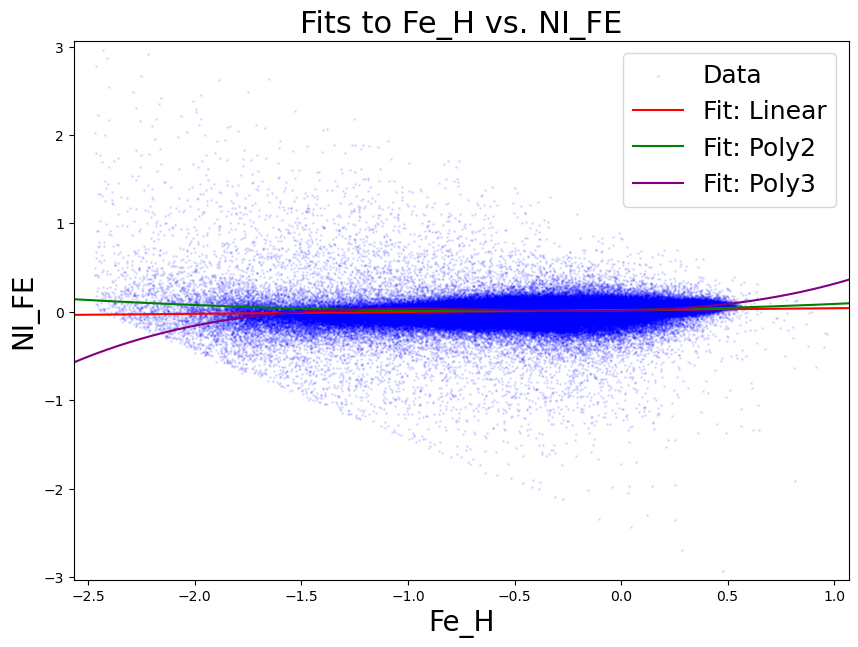

In [261]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def linear(x, a, b):
    return a * x + b

def poly2(x, A, B, C):
    return A * x**2 + B * x + C

def poly3(x, A, B, C, D):
    return A * x**3 + B * x**2 + C * x + D

badbits = 2**23
suspectbits = 2**16

ct7 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      (~np.isnan(star["Fe_H"])) & (~np.isnan(star["NI_FE"])) & \
      (~np.isnan(star["Fe_H_ERR"])) & (~np.isnan(star["NI_FE_ERR"]))

cut7 = np.where(ct7)

x_data = star['Fe_H'][cut7]
y_data = star['NI_FE'][cut7]

combined_err = np.sqrt(star['Fe_H_ERR'][cut7]**2 + star['NI_FE_ERR'][cut7]**2)

if len(x_data) == 0:
    print("No data points after filtering. Please check your filter conditions.")
else:
    params_linear, _ = curve_fit(linear, x_data, y_data, sigma=combined_err, p0=[0, 0])
    slope, intercept = params_linear
    print(f'Linear Fit: Slope = {slope:.2f}, Intercept = {intercept:.2f}')

    params_poly2, _ = curve_fit(poly2, x_data, y_data, sigma=combined_err, p0=[0, 0, 0])
    poly2_A, poly2_B, poly2_C = params_poly2
    print(f'Poly2 Fit: A = {poly2_A:.2f}, B = {poly2_B:.2f}, C = {poly2_C:.2f}')

    params_poly3, _ = curve_fit(poly3, x_data, y_data, sigma=combined_err, p0=[0, 0, 0, 0])
    poly3_A, poly3_B, poly3_C, poly3_D = params_poly3
    print(f'Poly3 Fit: A = {poly3_A:.2f}, B = {poly3_B:.2f}, C = {poly3_C:.2f}, D = {poly3_D:.2f}')

    fig, ax = plt.subplots(figsize=(10, 7))

    ax.scatter(x_data, y_data, s=1, c='b', alpha=0.1, label='Data')

    x_min, x_max = min(x_data), max(x_data)
    ax.set_xlim(x_min - 0.1, x_max + 0.1)
    ax.set_ylim(min(y_data) - 0.1, max(y_data) + 0.1)
    x_plot = np.linspace(x_min - 0.1, x_max + 0.1, 1000)

    ax.plot(x_plot, linear(x_plot, *params_linear), label='Fit: Linear', color='r')
    ax.plot(x_plot, poly2(x_plot, *params_poly2), label='Fit: Poly2', color='g')
    ax.plot(x_plot, poly3(x_plot, *params_poly3), label='Fit: Poly3', color='purple')

    ax.set_xlabel('Fe_H', fontsize=20)
    ax.set_ylabel('NI_FE', fontsize=20)
    ax.set_title('Fits to Fe_H vs. NI_FE', fontsize=22)
    plt.legend(loc='best', fontsize=18)

    plt.show()
